In [26]:
import os

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from pandas_profiling import ProfileReport # profile report を作る用
from matplotlib_venn import venn2 # venn図を作成する用

import lightgbm as lgbm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

In [27]:
INPUT_DIR = '../datasets/'
OUTPUT_DIR = '../outputs/'

os.makedirs(OUTPUT_DIR, exist_ok=True)

train_df = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))

train_feat_df = pd.read_csv(os.path.join(INPUT_DIR, 'pre1_train.csv'))
test_feat_df = pd.read_csv(os.path.join(INPUT_DIR, 'pre1_test.csv'))

In [31]:
print("train_df size: ", train_df.shape)
print("test_df size: ", test_df.shape)

print("train_feat_df size: ", train_feat_df.shape)
print("test_feat_df size: ", test_feat_df.shape)

train_df size:  (12026, 19)
test_df size:  (12008, 18)
train_feat_df size:  (12026, 27)
test_feat_df size:  (12008, 27)


In [36]:
# https://github.com/nyk510/vivid/blob/master/vivid/utils.py
from contextlib import contextmanager
from time import time

class Timer:
    def __init__(self, logger=None, format_str='{:.3f}[s]', prefix=None, suffix=None, sep=' '):

        if prefix: format_str = str(prefix) + sep + format_str
        if suffix: format_str = format_str + sep + str(suffix)
        self.format_str = format_str
        self.logger = logger
        self.start = None
        self.end = None

    @property
    def duration(self):
        if self.end is None:
            return 0
        return self.end - self.start

    def __enter__(self):
        self.start = time()

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end = time()
        out_str = self.format_str.format(self.duration)
        if self.logger:
            self.logger.info(out_str)
        else:
            print(out_str)

In [12]:
def fit_lgbm(X, 
             y, 
             cv, 
             params: dict=None, 
             verbose: int=50):
    """lightGBM を CrossValidation の枠組みで学習を行なう function"""

    # パラメータがないときは、空の dict で置き換える
    if params is None:
        params = {}

    models = []
    # training data の target と同じだけのゼロ配列を用意
    oof_pred = np.zeros_like(y, dtype=np.float)

    for i, (idx_train, idx_valid) in enumerate(cv): 
        # この部分が交差検証のところです。データセットを cv instance によって分割します
        # training data を trian/valid に分割
        x_train, y_train = X[idx_train], y[idx_train]
        x_valid, y_valid = X[idx_valid], y[idx_valid]

        clf = lgbm.LGBMRegressor(**params)

        with Timer(prefix='fit fold={} '.format(i)):
            clf.fit(x_train, y_train, 
                    eval_set=[(x_valid, y_valid)],  
                    early_stopping_rounds=100,
                    verbose=verbose)

        pred_i = clf.predict(x_valid)
        oof_pred[idx_valid] = pred_i
        models.append(clf)
        print(f'Fold {i} RMSLE: {mean_squared_error(y_valid, pred_i) ** .5:.4f}')

    score = mean_squared_error(y, oof_pred) ** .5
    print('-' * 50)
    print('FINISHED | Whole RMSLE: {:.4f}'.format(score))
    return oof_pred, models

In [13]:
params = {
    # 目的関数. これの意味で最小となるようなパラメータを探します. 
    'objective': 'rmse', 

     # 学習率. 小さいほどなめらかな決定境界が作られて性能向上に繋がる場合が多いです、
    # がそれだけ木を作るため学習に時間がかかります
    'learning_rate': .1,

    # L2 Reguralization
    'reg_lambda': 1.,
    # こちらは L1 
    'reg_alpha': .1,

    # 木の深さ. 深い木を許容するほどより複雑な交互作用を考慮するようになります
    'max_depth': 5, 

    # 木の最大数. early_stopping という枠組みで木の数は制御されるようにしていますのでとても大きい値を指定しておきます.
    'n_estimators': 10000, 

    # 木を作る際に考慮する特徴量の割合. 1以下を指定すると特徴をランダムに欠落させます。小さくすることで, まんべんなく特徴を使うという効果があります.
    'colsample_bytree': .5, 

    # 最小分割でのデータ数. 小さいとより細かい粒度の分割方法を許容します.
    'min_child_samples': 10,

    # bagging の頻度と割合
    'subsample_freq': 3,
    'subsample': .9,

    # 特徴重要度計算のロジック(後述)
    'importance_type': 'gain', 
    'random_state': 71,
}

# 予測値の変換

RMSLE を擬似的に RMSE として扱うため log1p 変換を行います。

In [32]:
y = train_df['likes'].values
y = np.log1p(y)
y

array([3.8918203 , 1.09861229, 1.79175947, ..., 0.        , 2.7080502 ,
       5.14749448])

# 交差検証にて学習

In [37]:
fold = KFold(n_splits=5, shuffle=True, random_state=71)
cv = list(fold.split(train_feat_df, y)) # もともとが generator なため明示的に list に変換する

oof, models = fit_lgbm(train_feat_df.values, y, cv, params=params, verbose=500)

<ipython-input-12-edf45865f986>:14: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  oof_pred = np.zeros_like(y, dtype=np.float)


Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[381]	valid_0's rmse: 1.18554
fit fold=0  0.514[s]
Fold 0 RMSLE: 1.1855
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[359]	valid_0's rmse: 1.17111
fit fold=1  0.369[s]
Fold 1 RMSLE: 1.1711
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[361]	valid_0's rmse: 1.16649
fit fold=2  0.343[s]
Fold 2 RMSLE: 1.1665
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[378]	valid_0's rmse: 1.1929
fit fold=3  0.386[s]
Fold 3 RMSLE: 1.1929
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[275]	valid_0's rmse: 1.17001
fit fold=4  0.308[s]
Fold 4 RMSLE: 1.1700
--------------------------------------------------
FINISHED | Whole RMSLE: 1.1773


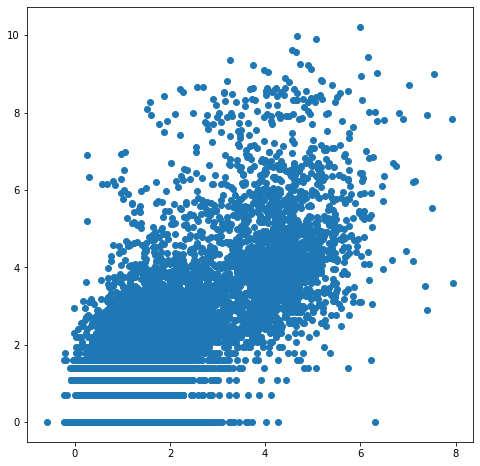

In [38]:
# 横軸予測値、縦軸正解値のプロット
# y = xに散らばり少なく分布するほど精度が高い
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(oof, y)

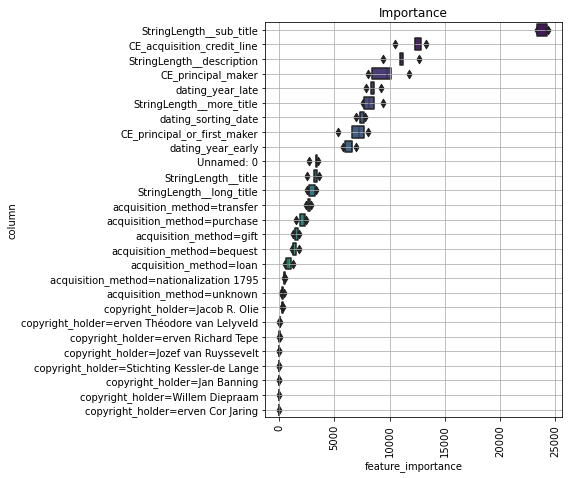

In [44]:
def visualize_importance(models, feat_train_df):
    """lightGBM の model 配列の feature importance を plot する
    CVごとのブレを boxen plot として表現します.

    args:
        models:
            List of lightGBM models
        feat_train_df:
            学習時に使った DataFrame
    """
    feature_importance_df = pd.DataFrame()
    for i, model in enumerate(models):
        _df = pd.DataFrame()
        _df['feature_importance'] = model.feature_importances_
        _df['column'] = feat_train_df.columns
        _df['fold'] = i + 1
        feature_importance_df = pd.concat([feature_importance_df, _df], 
                                          axis=0, ignore_index=True)

    order = feature_importance_df.groupby('column')\
        .sum()[['feature_importance']]\
        .sort_values('feature_importance', ascending=False).index[:50]

    fig, ax = plt.subplots(figsize=(8, max(6, len(order) * .25)))
    sns.boxenplot(data=feature_importance_df, 
                  x='feature_importance', 
                  y='column', 
                  order=order, 
                  ax=ax, 
                  palette='viridis', 
                  orient='h')
    ax.tick_params(axis='x', rotation=90)
    ax.set_title('Importance')
    ax.grid()
    fig.tight_layout()
    return fig, ax

fig, ax = visualize_importance(models, train_feat_df)
fig.savefig("../outputs/feature_importance.png")

In [40]:
# 予測値に対してlog1p変換を元に戻す関数
def revert_to_real(y_log):
    _pred = np.expm1(y_log)
    _pred = np.where(_pred < 0, 0, _pred)
    return _pred

In [41]:
pred = np.array([model.predict(test_feat_df.values) for model in models])
pred = np.mean(pred, axis=0)
pred = revert_to_real(pred)
sub_df = pd.DataFrame({ 'likes': pred })
sub_df.to_csv(os.path.join(OUTPUT_DIR, '0001__submission.csv'), index=False)

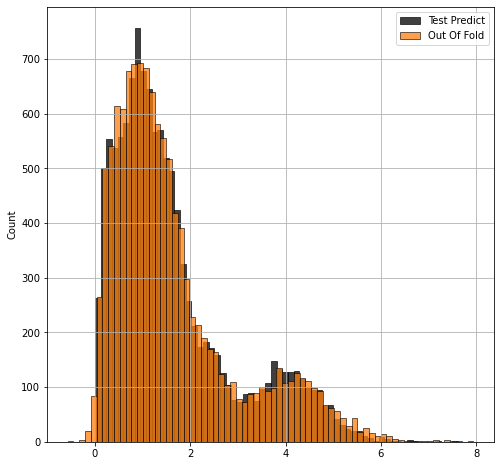

In [42]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.histplot(np.log1p(pred), label='Test Predict', ax=ax, color='black')
sns.histplot(oof, label='Out Of Fold', ax=ax, color='C1')
ax.legend()
ax.grid()